In [4]:
# pip install spacy sentence-transformers umap-learn scikit-learn matplotlib seaborn pdfminer.six

In [23]:
#!pip install spacy
#!pip show spacy

# this one didnt work for me : ! python -m spacy download en_core_web_sm
import sys
print(sys.executable)
!{sys.executable} -m spacy download en_core_web_sm


/opt/homebrew/opt/python@3.10/bin/python3.10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [27]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [ ]:
from spacy.lang.en import English

In [ ]:
import os
import pandas as pd
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
! tree . 

.
├── Climate+Change
│   ├── COP Meetings
│   │   ├── ECO-11-11-2024.pdf
│   │   ├── ECO-12-11-2024.pdf
│   │   ├── ECO-13-11-2024.pdf
│   │   ├── ECO-14-11-2024.pdf
│   │   ├── ECO-15-11-2024.pdf
│   │   ├── ECO-16-11-2024.pdf
│   │   ├── ECO-18-11-2024.pdf
│   │   ├── ECO-19-11-2024.pdf
│   │   ├── ECO-20-11-2024.pdf
│   │   ├── ECO-21-11-2024.pdf
│   │   ├── ECO-22-11-2024.pdf
│   │   ├── Earth Negotiations Bulletin.pdf
│   │   └── TWN - COP29.pdf
│   ├── Climate Policies
│   │   └── climate_policies.csv
│   ├── G7
│   │   ├── Canada
│   │   │   ├── Federal actions for a clean growth economy.pdf
│   │   │   └── Pan-Canadian Framework.pdf
│   │   ├── France
│   │   │   └── Integrated climate policy plan.pdf
│   │   ├── Germany
│   │   │   ├── Climate Action Plan 2050.pdf
│   │   │   └── German draft integrated National Energy and Climate Plan.pdf
│   │   ├── Italy
│   │   │   └── Italian draft integrated National Energy and Climate Plan.pdf
│   │   ├── Japan
│   │   │   └── Climate C

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from docx import Document
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from umap import UMAP
from pdfminer.high_level import extract_text
from pdfminer.pdfparser import PDFSyntaxError

Error processing Climate+Change/IPCC report/Summary for policymakers.txt: [E088] Text of length 1245609 exceeds maximum of 1000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`.
Error processing Climate+Change/IPCC report/6th assessment/WG3 - Mitigation of Climate Change.pdf: [E088] Text of length 12404132 exceeds maximum of 1000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are 

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/opt/homebrew/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


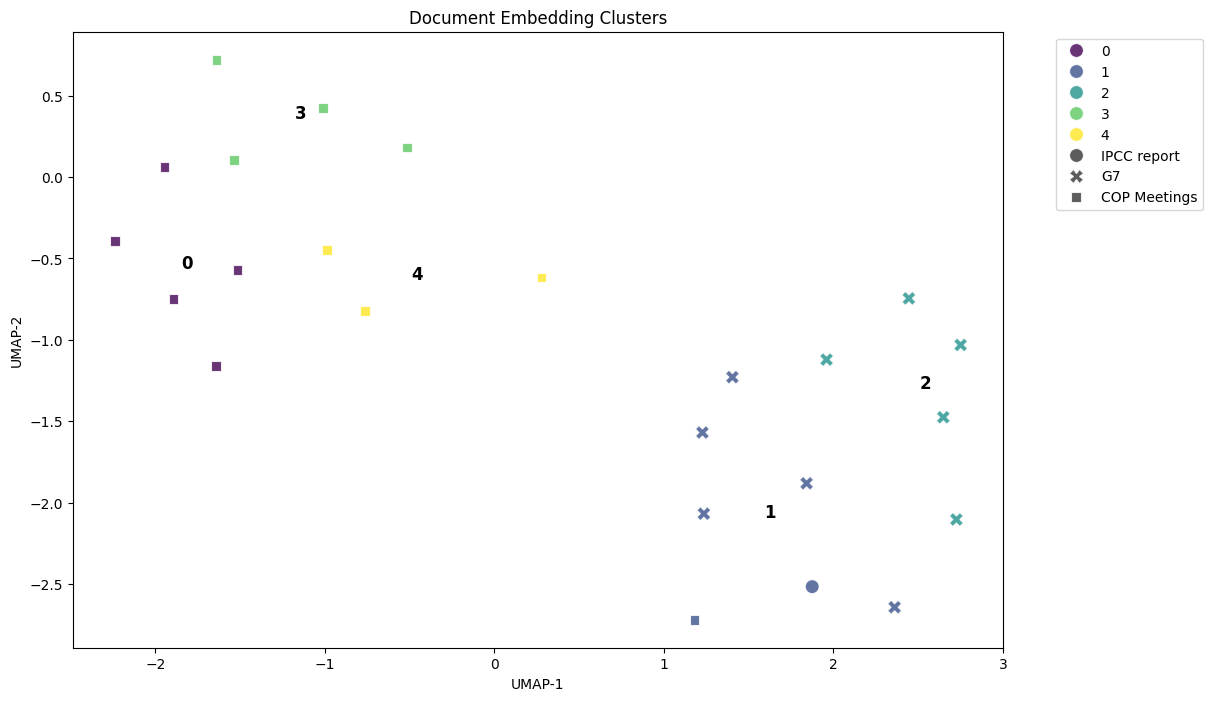


Cluster 0 (5 documents)
Common tokens: {'climate': 123, 'eco': 118, 'finance': 82, 'need': 63, 'country': 57, 'baku': 51, 'action': 38, 'party': 37, 'let': 36, 'right': 34}
Main sources: source
COP Meetings    5
Name: count, dtype: int64

Cluster 1 (7 documents)
Common tokens: {'climate': 2678, 'change': 1628, 'emission': 1440, 'high': 1333, 'include': 1066, 'adaptation': 1028, 'action': 1008, 'develop': 1000, 'confidence': 984, 'country': 929}
Main sources: source
G7              5
IPCC report     1
COP Meetings    1
Name: count, dtype: int64

Cluster 2 (5 documents)
Common tokens: {'energy': 6673, 'measure': 2608, 'climate': 2442, 'sector': 1999, 'electricity': 1951, 'system': 1688, 'renewable': 1671, 'plan': 1629, 'gas': 1608, 'national': 1490}
Main sources: source
G7    5
Name: count, dtype: int64

Cluster 3 (4 documents)
Common tokens: {'climate': 141, 'eco': 89, 'finance': 85, 'country': 84, 'need': 50, 'adaptation': 47, 'develop': 41, 'global': 38, 'baku': 36, 'year': 35}
Main 

In [ ]:
# Initialize NLP pipeline
nlp = spacy.load("en_core_web_sm")
tokenizer = nlp.tokenizer

# Initialize embedding model
embedder = SentenceTransformer('all-MiniLM-L6-v2')



def load_and_process_documents(root_dir):
    """Load and tokenize documents from directory structure
    
    Walks through the directory recursively
    Handles different file types (.pdf, .txt, .docx)
    For each document:

        Extracts text (special handling for PDFs)
        tokenizes the text using SpaCy
        Removes stop words and keeps only alphabetic tokens
        Creates a dictionary with file info and processed text"""
    
    documents = []
    
    for path in Path(root_dir).rglob('*.*'):
        if path.suffix.lower() in ['.pdf', '.txt', '.docx']:
            try:
                # Read file content
                if path.suffix == '.pdf':
                    text = extract_text_from_pdf(path)
                else:
                    text = path.read_text(encoding='utf-8')
                
                # Tokenize and clean
                doc = nlp(text)
                tokens = [token.lemma_.lower() for token in doc 
                         if not token.is_stop and token.is_alpha]
                
                documents.append({
                    'path': str(path),
                    'text': text,
                    'tokens': tokens,
                    'source': path.parts[1]  # Get parent directory name
                })
            except Exception as e:
                print(f"Error processing {path}: {e}")
    
    return pd.DataFrame(documents)

def extract_text_from_pdf(pdf_path):
    """Extract text from PDF files
    A helper function that uses pdfminer to extract text from PDF files."""
    from pdfminer.high_level import extract_text
    return extract_text(pdf_path)

def generate_embeddings(df):
    """Generate sentence embeddings for documents            
        Takes the processed documents
        Joins tokens back into text
        Uses SentenceTransformer to create embeddings
        Returns numerical representations of the documents"""
    texts = [' '.join(doc['tokens']) for doc in df.to_dict('records')]
    return embedder.encode(texts, show_progress_bar=True)

def cluster_documents(embeddings, n_clusters=5):
    """Perform dimensionality reduction and clustering
    
    Uses UMAP for dimensionality reduction (converting high-dimensional embeddings to 2D)
    Applies K-means clustering to group similar documents
    Returns both the 2D embeddings and cluster assignments """
    # Reduce dimensions
    umap_embeddings = UMAP(n_components=2).fit_transform(embeddings)
    
    # Cluster using K-means
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(umap_embeddings)
    
    return umap_embeddings, clusters

def visualize_clusters(embeddings, clusters, df):
    """Visualize document clusters"""
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x=embeddings[:, 0],
        y=embeddings[:, 1],
        hue=clusters,
        style=df['source'],
        palette="viridis",
        s=100,
        alpha=0.8
    )
    
    # Add annotations for cluster centers
    for cluster in set(clusters):
        center = embeddings[clusters == cluster].mean(axis=0)
        plt.text(center[0], center[1], str(cluster), 
                fontdict={'weight': 'bold', 'size': 12})
    
    plt.title("Document Embedding Clusters")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Main workflow
if __name__ == "__main__":
    # Load and process documents
    root_dir = "./Climate+Change"
    df = load_and_process_documents(root_dir)
    
    # Generate embeddings
    embeddings = generate_embeddings(df)    
    # Cluster documents
    umap_embeddings, clusters = cluster_documents(embeddings, n_clusters=5)

    # Use ClimateBERT for better climate-specific embeddings
    # embedder = SentenceTransformer('climatebert/distilroberta-base-climate-f')
    
    # Add results to DataFrame
    df['cluster'] = clusters
    df['x'] = umap_embeddings[:, 0]
    df['y'] = umap_embeddings[:, 1]
    
    # Visualize
    visualize_clusters(umap_embeddings, clusters, df)
    
    # Show cluster characteristics
    for cluster in sorted(df['cluster'].unique()):
        cluster_docs = df[df['cluster'] == cluster]
        print(f"\nCluster {cluster} ({len(cluster_docs)} documents)")
        print("Common tokens:", pd.Series(
            [token for tokens in cluster_docs['tokens'] for token in tokens]
        ).value_counts().head(10).to_dict())
        print("Main sources:", cluster_docs['source'].value_counts().head(3))

The main execution:

Loads and processes documents from the Climate+Change directory
Generates embeddings for all documents
Performs clustering
Adds results to the DataFrame
Creates visualization
Prints cluster characteristics:

Number of documents per cluster
Most common tokens in each cluster
Main document sources in each cluster



Key Features:

Uses UMAP for dimensionality reduction (better than t-SNE for larger datasets)
Combines multiple NLP tools (SpaCy, SentenceTransformer)
Handles multiple file types
Provides both visualization and statistical analysis
Comments suggest using ClimateBERT for domain-specific embeddings

Common Use Cases:

Understanding document relationships
Finding thematic clusters in policy documents
Identifying patterns across different document sources
Comparing policies from different regions/organizations

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

# Perform LDA on clustered documents
vectorizer = CountVectorizer(max_df=0.95, min_df=2)
dtm = vectorizer.fit_transform(df['text'])
lda = LatentDirichletAllocation(n_components=5)
lda.fit(dtm)

In [ ]:
# !pip install pdfplumber spacy transformers torch datasets peft pandas wandb

In [51]:
!tree

.
├── Climate+Change
│   ├── COP Meetings
│   │   ├── ECO-11-11-2024.pdf
│   │   ├── ECO-12-11-2024.pdf
│   │   ├── ECO-13-11-2024.pdf
│   │   ├── ECO-14-11-2024.pdf
│   │   ├── ECO-15-11-2024.pdf
│   │   ├── ECO-16-11-2024.pdf
│   │   ├── ECO-18-11-2024.pdf
│   │   ├── ECO-19-11-2024.pdf
│   │   ├── ECO-20-11-2024.pdf
│   │   ├── ECO-21-11-2024.pdf
│   │   ├── ECO-22-11-2024.pdf
│   │   ├── Earth Negotiations Bulletin.pdf
│   │   └── TWN - COP29.pdf
│   ├── Climate Policies
│   │   └── climate_policies.csv
│   ├── G7
│   │   ├── Canada
│   │   │   ├── Federal actions for a clean growth economy.pdf
│   │   │   └── Pan-Canadian Framework.pdf
│   │   ├── France
│   │   │   └── Integrated climate policy plan.pdf
│   │   ├── Germany
│   │   │   ├── Climate Action Plan 2050.pdf
│   │   │   └── German draft integrated National Energy and Climate Plan.pdf
│   │   ├── Italy
│   │   │   └── Italian draft integrated National Energy and Climate Plan.pdf
│   │   ├── Japan
│   │   │   └── Climate C

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Preprocessing

In [53]:
import os
from typing import List, Dict, Any
import pandas as pd
import pdfplumber
from pathlib import Path
import spacy
from transformers import AutoTokenizer, AutoModel
import torch
from datasets import Dataset
from peft import LoraConfig, TaskType, get_peft_model
import json


In [54]:
!pip install pdf_reader

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: Could not find a version that satisfies the requirement pdf_reader (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
ERROR: No matching distribution found for pdf_reader
